# Unsupervised Clustering
**Unsupervised** methods are the methods which allow us to pull out some structure automatically without having data labels.

## What is Clustering?
Clustering is a key data science method that summarizes data by grouping similar points together, rather than reducing dimensions like in dimensionality reduction. Each data point is assumed to come from a distribution, and clusters represent groups of similar points.  \
**Goal:**
1. Assign each point a cluster
2. Describe the clusters by, for example, drawing a shape around them
3. Answer the question: are two points in same cluster?

### Lower Dimension Example
Here's an example of clustering that we can easily visualize.

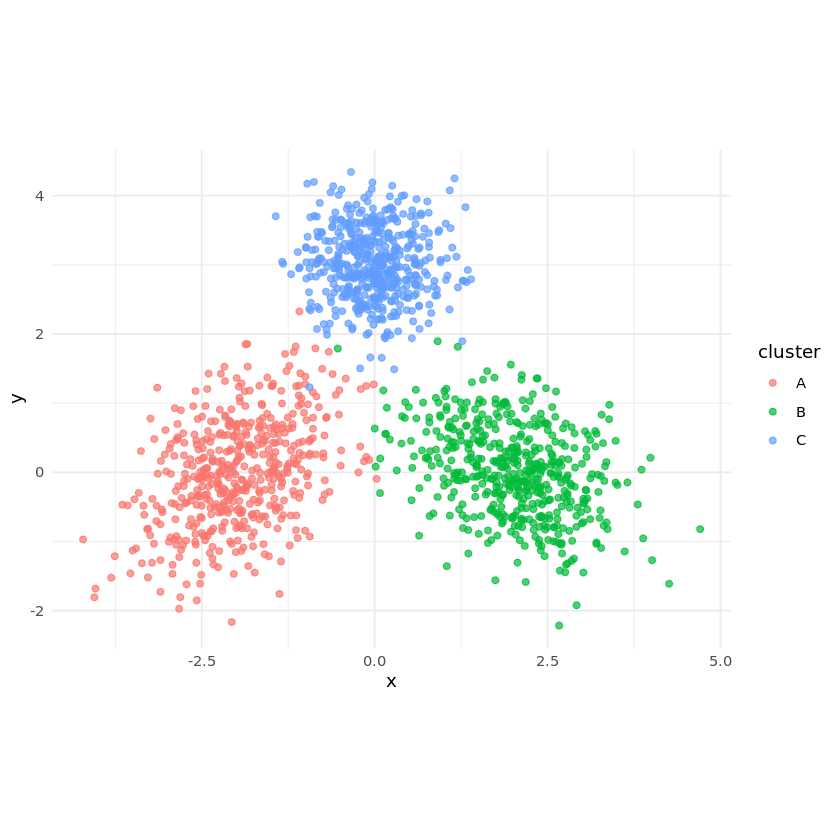

In [1]:
suppressPackageStartupMessages(library(tidyverse))

gaussian_clusters <- function(
  n = c(500, 500, 500),
  means = list(c(-2, 0), c(2, 0), c(0, 3)),
  covs = list(
    matrix(c(1.0,  0.5,
             0.5,  1.2)/2, 2, byrow = TRUE),
    matrix(c(1.2, -0.4,
            -0.4,  0.8)/2, 2, byrow = TRUE),
    matrix(c(0.5,  0.0,
             0.0,  0.5)/2, 2, byrow = TRUE)
  ),
  seed = 1L,
  labels = c("A","B","C")
) {
  stopifnot(length(n) == 3, length(means) == 3, length(covs) == 3)
  set.seed(seed)
  pieces <- Map(function(nn, mu, S) MASS::mvrnorm(nn, mu = mu, Sigma = S),
                n, means, covs)
  df <- as.data.frame(do.call(rbind, pieces))
  names(df) <- c("x", "y")
  df$cluster <- factor(rep(seq_along(n), n), labels = labels)
  df
}

# generate 3 Gaussian clusters in 2D and scatter plot
df <- gaussian_clusters()

ggplot(df, aes(x, y, color = cluster)) +
  geom_point(alpha = 0.7, size = 1.6) +
  coord_equal() +
  theme_minimal()

### Higher Dimension Example
This code creates synthetic data in 12 dimensions, generates three clusters (A, B, C) by drawing points from multivariate Gaussian distributions, then makes a scatterplot matrix of all 12 variables, colored by cluster. Then, we did PCA and plotted the first two components.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



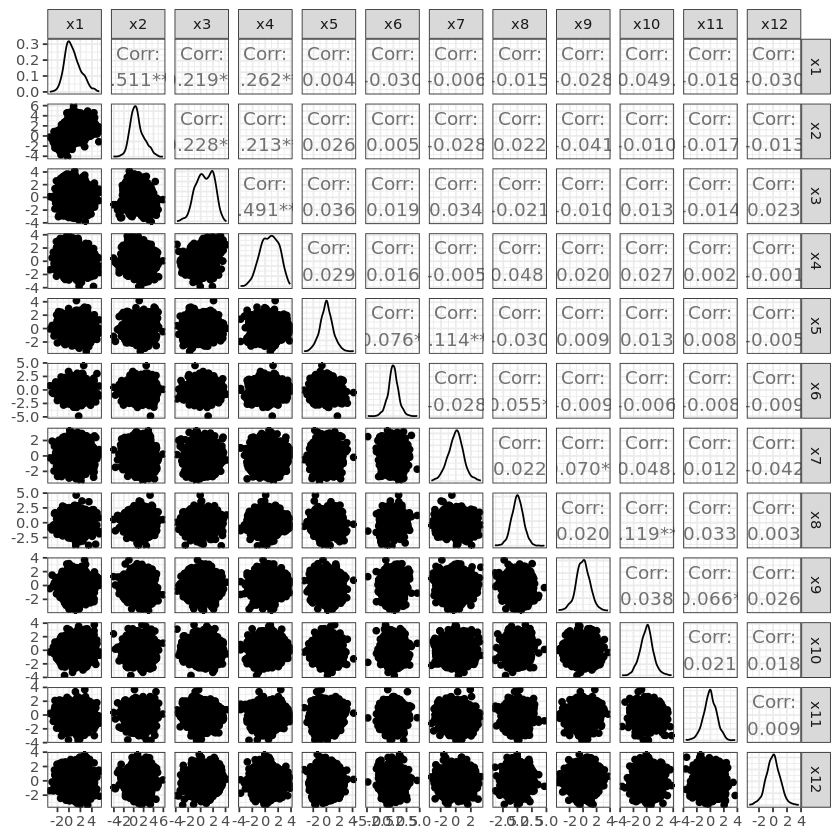

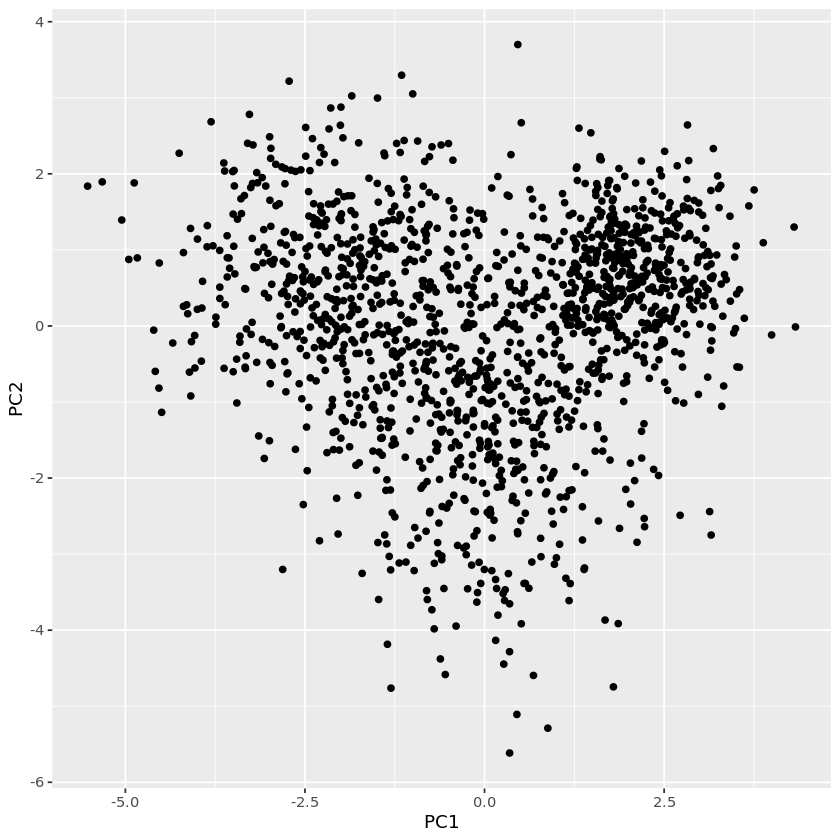

In [2]:
library(GGally)

gaussian_clusters_12d <- function(
  n = c(500, 500, 500),
  means = list(
    rep(0, 12),
    c(2, 2, rep(0, 10)),
    c(rep(0, 2), 2, 2, rep(0, 8))
  ),
  sigmas = c(1.0, 1.2, 0.7),
  rhos   = c(0.3, -0.2, 0.1),
  seed = 1L,
  labels = c("A", "B", "C")
) {
  stopifnot(length(n) == 3, length(means) == 3,
            length(sigmas) == 3, length(rhos) == 3)

  ar_cov <- function(p, sigma = 1, rho = 0.3) {
    i <- 0:(p - 1)
    Sigma <- outer(i, i, function(a, b) rho^abs(a - b))
    Sigma * (sigma^2)
  }

  p <- 12
  covs <- Map(function(s, r) ar_cov(p, sigma = s, rho = r), sigmas, rhos)

  set.seed(seed)
  pieces <- Map(function(nn, mu, S) MASS::mvrnorm(nn, mu = mu, Sigma = S),
                n, means, covs)

  df <- as.data.frame(do.call(rbind, pieces))
  names(df) <- paste0("x", seq_len(p))
  df$cluster <- factor(rep(seq_along(n), n), labels = labels)

  df
}

df <- gaussian_clusters_12d()

p <- GGally::ggpairs(df, columns = 1:12, progress = T) +
  theme_bw()

p

pr <- prcomp(df %>% select(-cluster))

ggplot(pr$x %>% as_tibble(), aes(PC1,PC2)) + geom_point()

## K-Means
K-means is to clustering what PCA is to dimensionality reduction. It's the simplest method that produces useful results.
1. Randomly assign points to clusters.
2. Compute cluster centroids (means).
3. Reassign points to the nearest centroid.
4. Recompute centroids.
5. Repeat until convergence (assignments no longer change).

### The Algorithm
Given a number of clusters to search for N: 
1.  Assign each point to a cluster N at random.
2.  Calculate the mean position of each cluster using the previous assignments.
3.  Loop through the points - assign each point to the cluster to whose center it is closest.
4.  Repeat this process until the centers stop moving around.

### Assumptions of K-Means
The assumption of this procedure are as follows:
1.  The data is in a vector space (why?)
2.  The clusters are characterized by their centers or centroids
3.  Cluster membership falls off at a similar rate from all centroids
4.  Clusters are about the same size
(These correspond roughly to the assumption that the clusters are spherical gaussians in N dimensions with the same or similar standard deviations).

A little bit like PCA - there really is no reason to ever expect these conditions to be true but somehow k-means works pretty well pretty often!

## K-Means Demo: Super Simple Example
This was in the part of the lecture where we were going through the `.html` example slides.
#### Step 0. Load the data.
I don't have the exact code the was used in lecture to generate this data, so here's the data generation and the plot of the data without labels.


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




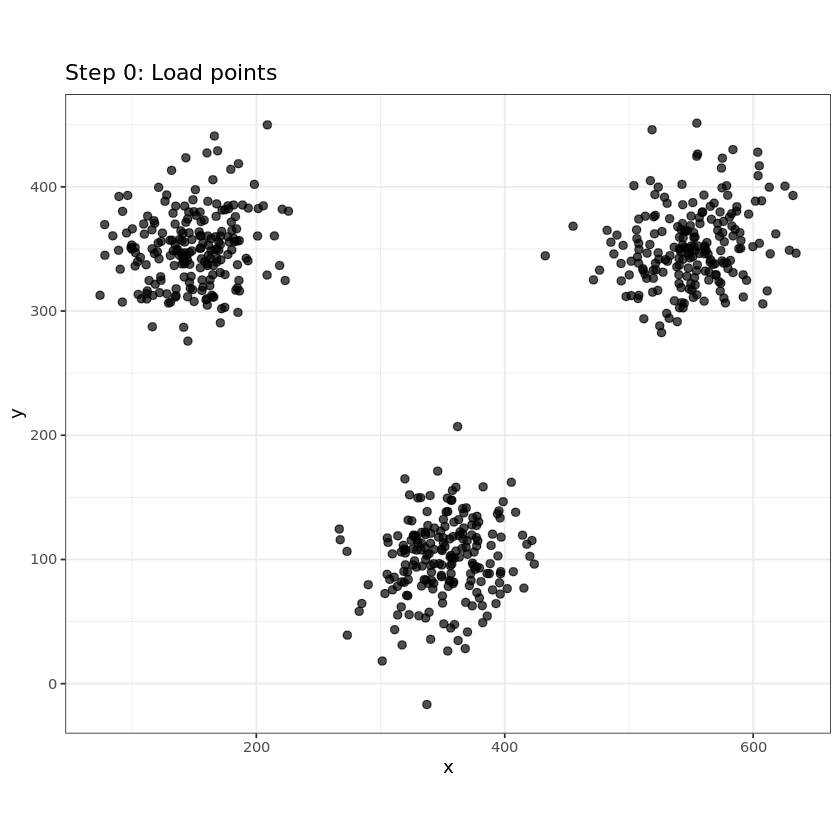

In [3]:
# Generating our data...
    # Normally, you'd be loading a data set in, but for the demo we'll generate it.
set.seed(123)

n <- 200

centers <- data.frame(
  cx = c(150, 350, 550),
  cy = c(350, 100, 350)
)

Sigma <- matrix(c(1000, 200, 
                  200, 1000), nrow = 2)  

library(MASS)

g1 <- as.data.frame(mvrnorm(n, mu = c(centers$cx[1], centers$cy[1]), Sigma))
g2 <- as.data.frame(mvrnorm(n, mu = c(centers$cx[2], centers$cy[2]), Sigma))
g3 <- as.data.frame(mvrnorm(n, mu = c(centers$cx[3], centers$cy[3]), Sigma))

df <- rbind(g1, g2, g3)
names(df) <- c("x", "y")

ggplot(df, aes(x, y)) +
  geom_point(size = 2, alpha = 0.7) +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 0: Load points")

#### Step 1. Assign points to clusters at random.

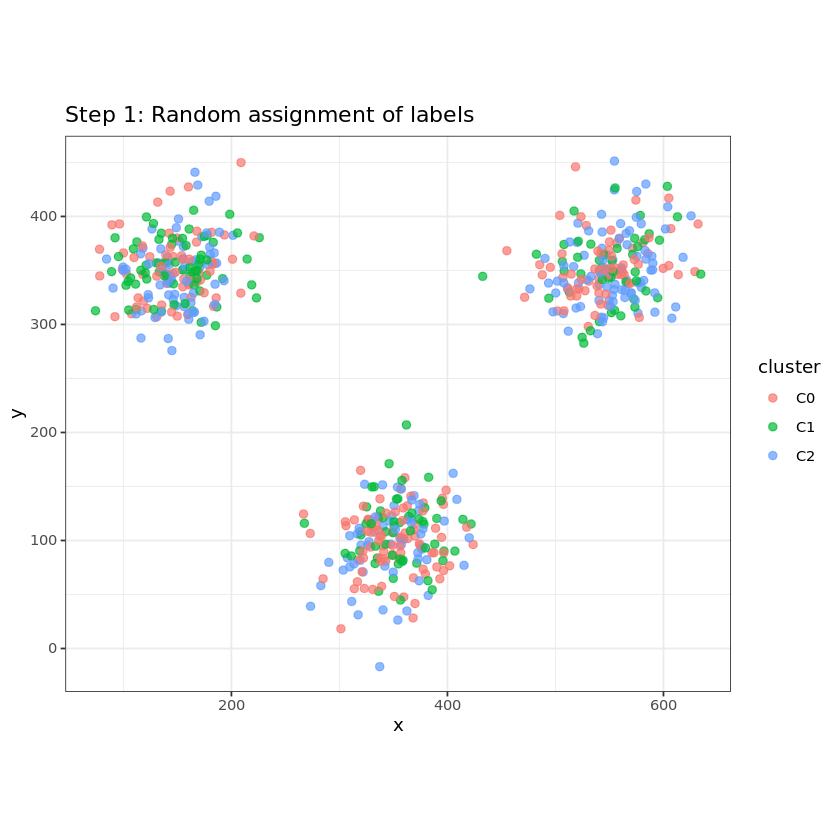

In [4]:
df$cluster <- sample(c("C0", "C1", "C2"), nrow(df), replace = TRUE)

library(ggplot2)
ggplot(df, aes(x, y, color = cluster)) +
  geom_point(size = 2, alpha = 0.7) +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 1: Random assignment of labels")

#### Step 2: Compute cluster means (centroids)
**The trick with k-means is an oscillation back and forth between which pieces of data we're treating as the authoritative piece of pieces of data describing the clusters, and which ones are the derived data.** We're going to say that a cluster is defined by the points inside the cluster. For each cluster that we have, we're going to calculate the center of the cluster by calculating the average position of all the points in the cluster. 

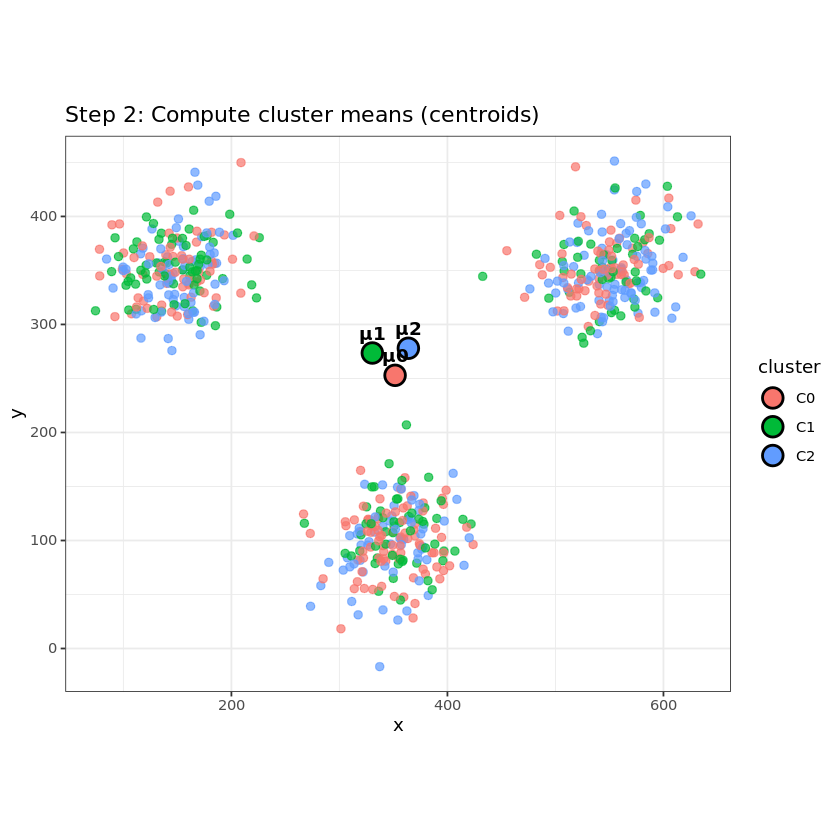

In [5]:
# compute centroids
centers_df <- df %>%
  group_by(cluster) %>%
  summarise(
    x = mean(x),
    y = mean(y),
    .groups = "drop"
  ) %>%
  arrange(cluster) %>%
  mutate(label = paste0("μ", row_number() - 1))

# plot with centroids
ggplot(df, aes(x, y, color = cluster)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_point(data = centers_df, aes(x, y, fill = cluster),
             shape = 21, size = 5, color = "black", stroke = 1.2) +
  geom_text(data = centers_df, aes(x, y, label = label),
            vjust = -1, fontface = "bold", color = "black") +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 2: Compute cluster means (centroids)")

#### Step 3+: Iterate, reassign labels, recompute means
Now that we've calculated the centers, we're going to **treat the centers as the official representation of the cluster**, and we're going to ask ourselves the question:  
Given a set of centers, which points belong to that center?  
Answer: The points closest to the center belong to that center.

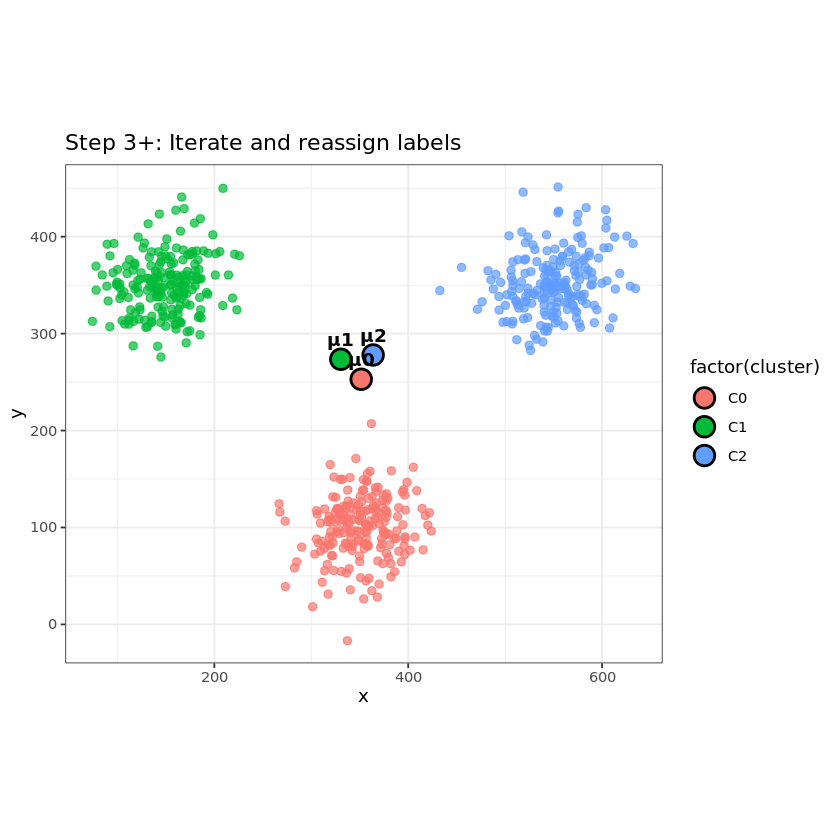

In [6]:
# function to assign each point to the nearest original centroid
assign_to_nearest <- function(df_points, centers) {
  df_points %>%
    rowwise() %>%
    mutate(
      cluster = centers$cluster[which.min(sqrt((x - centers$x)^2 + (y - centers$y)^2))]
    ) %>%
    ungroup()
}

# reassign clusters based on original centroids
df_new <- assign_to_nearest(df, centers_df)

# plot points with new clusters but original centroids
ggplot(df_new, aes(x, y, color = factor(cluster))) +
  geom_point(size = 2, alpha = 0.7) +
  geom_point(data = centers_df, aes(x, y, fill = factor(cluster)),
             shape = 21, size = 5, color = "black", stroke = 1.2) +
  geom_text(data = centers_df, aes(x, y, label = label),
            vjust = -1, fontface = "bold", color = "black") +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 3+: Iterate and reassign labels")

Then, we calculate the new means.

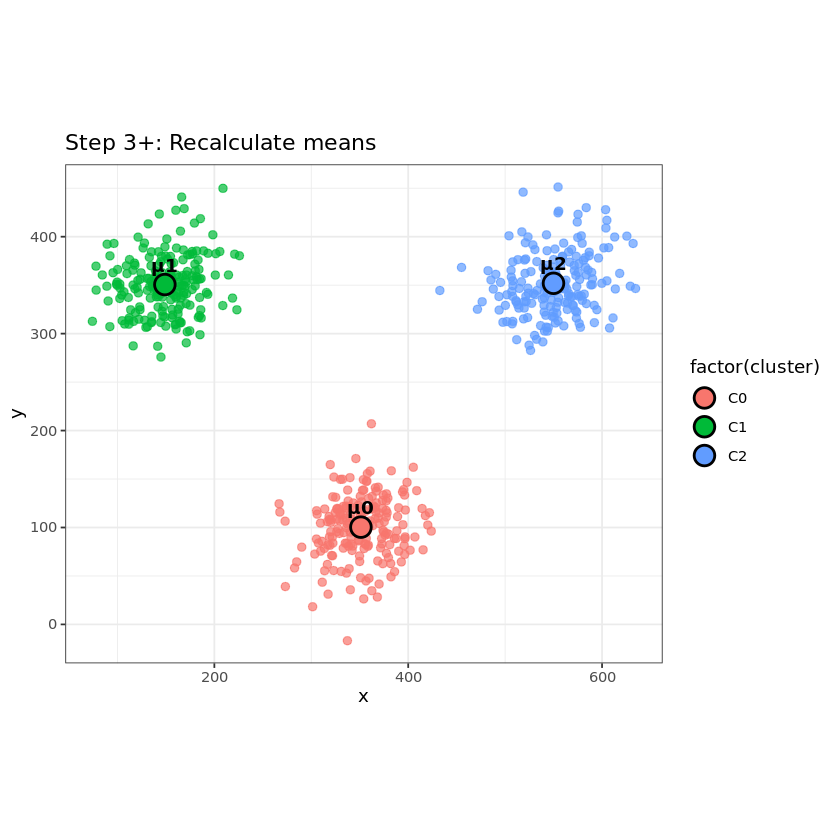

In [7]:
# compute new centroids based on reassigned clusters
new_centers_df <- df_new %>%
  group_by(cluster) %>%
  summarise(
    x = mean(x),
    y = mean(y),
    .groups = "drop"
  ) %>%
  arrange(cluster) %>%
  mutate(label = paste0("μ", row_number() - 1))

# plot updated clusters
ggplot(df_new, aes(x, y, color = factor(cluster))) +
  geom_point(size = 2, alpha = 0.7) +
  geom_point(data = new_centers_df, aes(x, y, fill = factor(cluster)),
             shape = 21, size = 5, color = "black", stroke = 1.2) +
  geom_text(data = new_centers_df, aes(x, y, label = label),
            vjust = -1, fontface = "bold", color = "black") +
  coord_equal() +
  theme_bw() +
  ggtitle("Step 3+: Recalculate means")

Sometimes it doesn't converge on the first iteration, so you'll more than one iteration!

#### What did we accomplish?
We got:
1. **A label** for each data point, which corresponds to a cluster
2. **The mean** of each cluster

## Writing K-Means Ourselves!

#### Here's what was completed in class. Finishing and implementing this on data will be on Homework 8!

#### Important Notes
##### Assigning Clusters in K-Means (by Hand)

The goal is to implement the **`assign_cluster`** step of K-Means manually.

**Setup**:  
- **`data`**: an $N \times K$ matrix — $N$ points, each $D$-dimensional.  
- **`means`**: a $K \times D$ matrix — $K$ cluster centroids.

**Slow Approach**:  
For each data point $i$, loop over all clusters $j$ and compute the distance between the point and each cluster mean.  
This double loop (over $N$ and $K$) is slow.

**Fast Approach**:  
This is called vectorizing a piece of code. Instead of looping, construct two large replicated matrices so that all point–cluster pairs can be compared at once:  

- **`Data′` (Data Prime):** replicate each data point $K$ times — one copy for each cluster.  
- **`Means′` (Means Prime):** replicate each cluster mean $N$ times — one copy for each data point.  

These two replicated matrices are now the same shape $N \times K \times D$, so we can **subtract them directly** and compute all distances in one vectorized operation.  
By cleverly constructing index vectors with repeated entries (e.g., using R’s `rep()`), we can generate the replicated matrices efficiently **without explicit loops**.  

**Next - Assignment**:  
1. Compute squared distances between every data point and every cluster.  
2. For each data point, find the **minimum distance** (the nearest cluster).  
3. In tidyverse form:
   ```
   tibble(data_index, cluster_index, distance) %>%
     group_by(data_index) %>%
     arrange(distance) %>%
     slice(1)
   ```

In [8]:
label_randomly <- function(n_points, n_clusters){
  sample(((1:n_points) %% n_clusters)+1, n_points, replace=F)
}

get_cluster_means <- function(data, labels){
  data %>%
    mutate(label__ = labels) %>%
    group_by(label__) %>%
    summarize(across(everything(), mean), .groups = "drop") %>%
    arrange(label__)
}

assign_cluster_fast <- function(data, means){
  data_matrix <- as.matrix(data)
  means_matrix <- as.matrix(means %>% dplyr::select(-label__))
  dii <- sort(rep(1:nrow(data), nrow(means)))
  mii <- rep(1:nrow(means), nrow(data))
  data_repped <- data_matrix[dii, ]
  means_repped <- means_matrix[mii, ]
  diff_squared <- (data_repped - means_repped)^2
  all_distances <- rowSums(diff_squared)
  tibble(dii=dii, mii=mii, distance=all_distances) %>%
    group_by(dii) %>%
    arrange(distance) %>%
    filter(row_number()==1) %>%
    ungroup() %>%
    arrange(dii) %>%
    pull(mii)
}

assign_cluster_slow <- function(data, means){    
  dii <- 1:nrow(data)
  cii <- 1:nrow(means)
  labels <- c()
  for(point_index in dii){
    smallest_dist <- Inf
    smallest_label <- NA
    for(clus_index in cii){
      point <- data[point_index, ]
      clus <- means %>% dplyr::select(-label__) %>% `[`(clus_index, )
      diff <- point - clus
      dist <- sum(diff * diff)
      if(dist < smallest_dist){
        smallest_dist <- dist
        smallest_label <- means[clus_index, ]$label__
      }
    }
    labels <- c(labels, smallest_label)
  }        
  labels    
}

kmeans_done <- function(old_means, new_means, eps=1e-6){
  om <- as.matrix(old_means)
  nm <- as.matrix(new_means)
  m <- mean(sqrt(rowSums((om - nm)^2)))
  if(m < eps) TRUE else FALSE
}

mykmeans <- function(data, n_clusters, eps=1e-6, max_it = 1000, verbose = FALSE){
  labels <- label_randomly(nrow(data), n_clusters)
  old_means <- get_cluster_means(data, labels)
  done <- FALSE
  it <- 0
  while(!done & it < max_it){
    labels <- assign_cluster_fast(data, old_means)
    new_means <- get_cluster_means(data, labels)
    if(kmeans_done(old_means, new_means)){
      done <- TRUE
    } else {
      old_means <- new_means
      it <- it + 1
      if(verbose){
        cat(sprintf("%d\n", it))
      }
    }
  }
  list(labels=labels, means=new_means)
}

## K-Means Example: Voltage Traces
Here's data we've seen before - voltage traces! 

The first plot shows the true clusters, and the last plot shows the clusters separated by k-means, labeled by the true labels. As we can see, they were separated correctly, but not labeled correctly. 


Attaching package: ‘matlab’


The following object is masked from ‘package:stats’:

    reshape


The following objects are masked from ‘package:utils’:

    find, fix


The following object is masked from ‘package:base’:

    sum




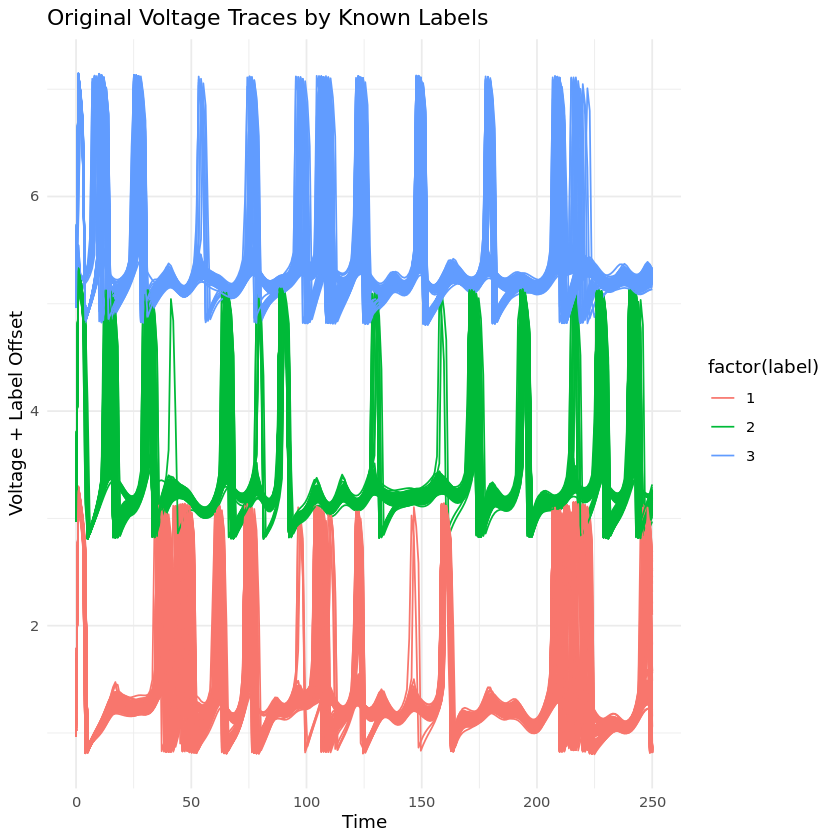

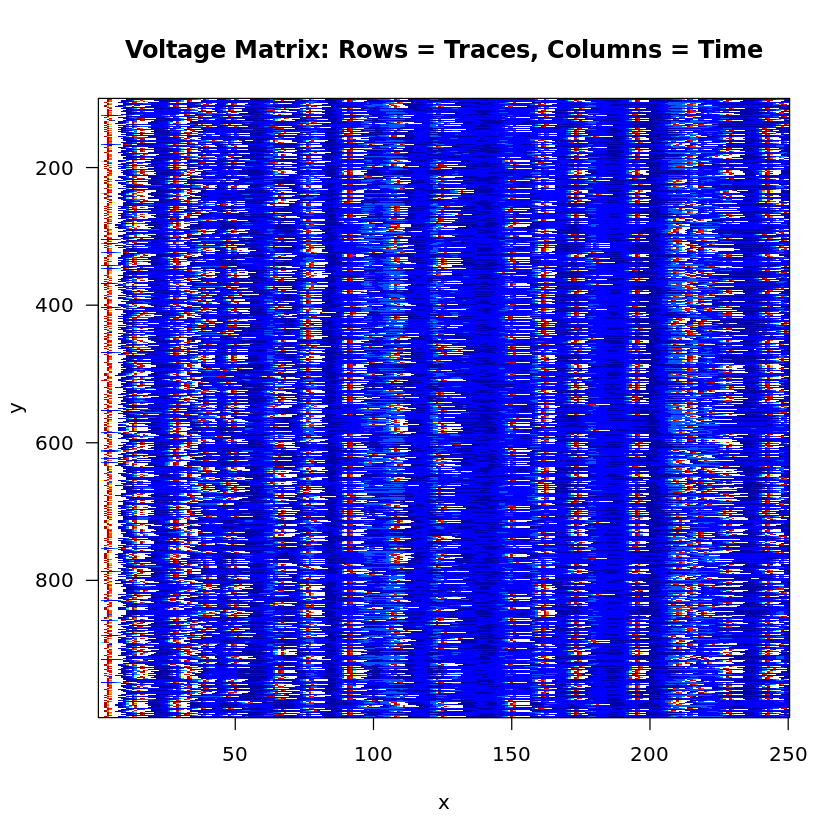

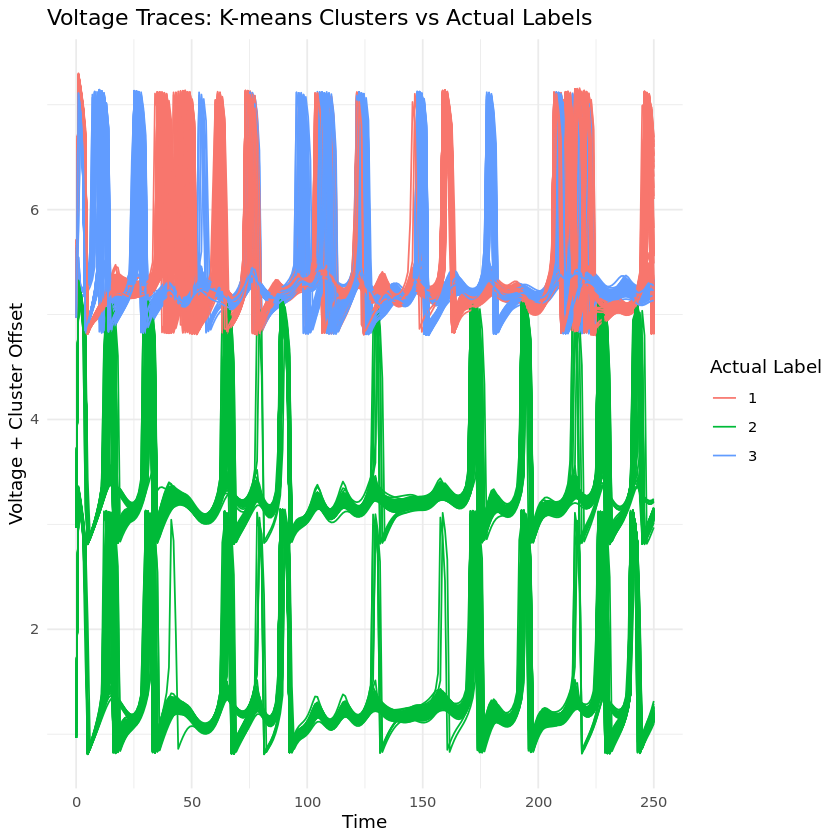

In [9]:
library(tidyverse)
library(matlab)

voltages <- suppressMessages(read_csv("voltages.csv"))

ggplot(voltages, aes(time, V + label*2)) + 
  geom_line(aes(color=factor(label),
                group=sprintf("%d:%d", trial, label))) +
  ggtitle("Original Voltage Traces by Known Labels") +
  ylab("Voltage + Label Offset") +
  xlab("Time") +
  theme_minimal()

voltages_wide <- voltages %>%
  arrange(time) %>%
  pivot_wider(id_cols = c("trial", "label"),
              names_from = "time",
              values_from = "V") %>%
  mutate(index = 1:nrow(.)) %>%
  arrange(runif(nrow(.)))

voltages_matrix <- voltages_wide %>% 
  dplyr::select(-trial, -label, -index) %>% 
  as.matrix()

imagesc(voltages_matrix)
title("Voltage Matrix: Rows = Traces, Columns = Time")

results <- kmeans(voltages_matrix, centers = 3)

voltages_ex <- voltages %>% 
  left_join(
    voltages_wide %>%
      mutate(cluster = results$cluster) %>%
      dplyr::select(trial, label, cluster),
    by = c("trial", "label")
  )

ggplot(voltages_ex, aes(time, V + cluster*2)) +
  geom_line(aes(group = sprintf("%d:%d", trial, label),
                color = factor(label))) +
  ggtitle("Voltage Traces: K-means Clusters vs Actual Labels") +
  ylab("Voltage + Cluster Offset") +
  xlab("Time") +
  theme_minimal() +
  labs(color = "Actual Label")

### Mutual Information

We have labels in this situation (1,2,3) and clusters, also indexed (1,2,3). K-means, even if it behaves perfectly, isn't guaranteed to give the cluster label 1 to the elements in group 1. For example, group 1 might be given cluster label 3, group 2 cluster label 1, and group 3 cluster label 2.

How do we compare labelings in general?

One strategy might be to calculate the centers of each labelled group and compare them to the cluster centers given by k-means:

`summarise()` has grouped output by 'time'. You can override using the
`.groups` argument.

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




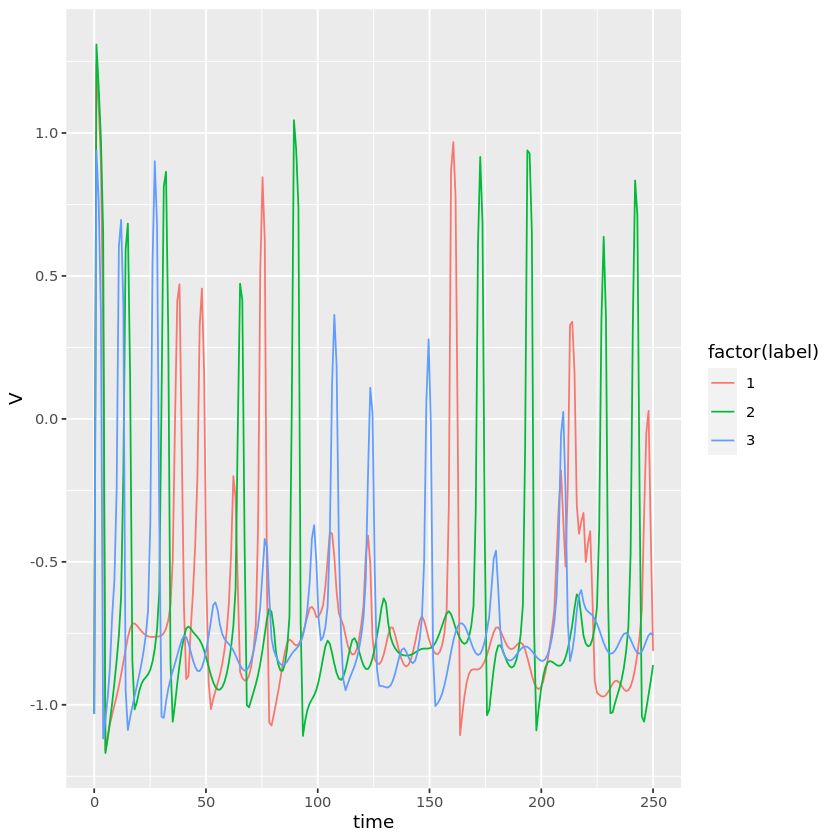

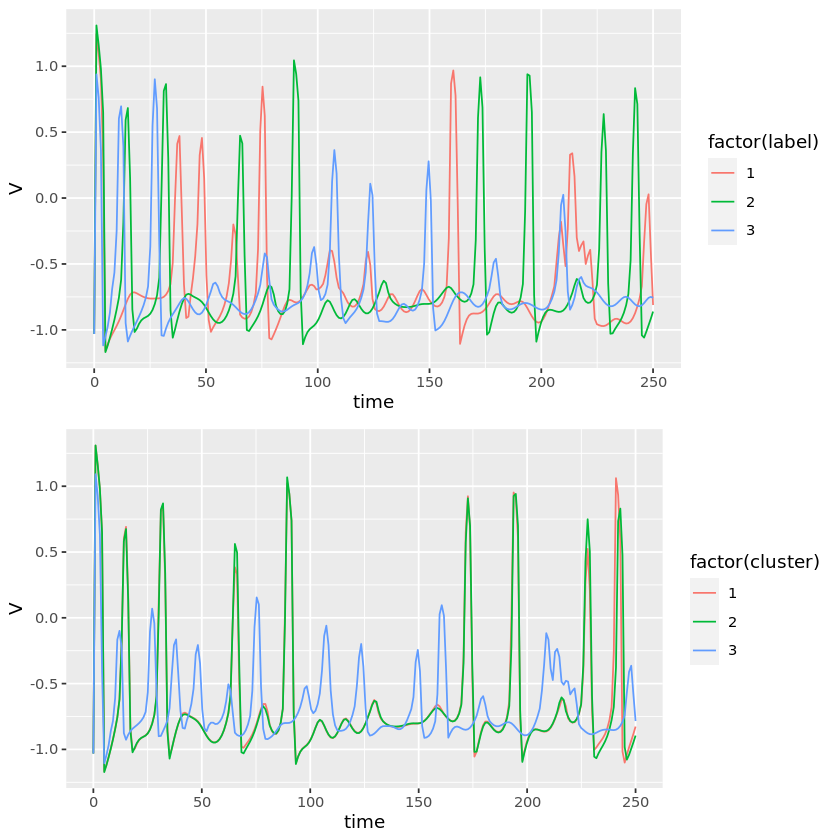

In [10]:
label_centers <- voltages %>%
    group_by(time, label) %>%
    summarize(V=mean(V)) %>%
    ungroup();

p1 <- ggplot(label_centers, aes(time,V)) + geom_line(aes(color=factor(label), group=label));
p1

cluster_centers <- results$centers %>% t() %>% as_tibble(rownames="time") %>%
    pivot_longer(cols=c(`1`,`2`,`3`)) %>% rename(cluster=name, V=value) %>%
    mutate(time=as.numeric(time)) %>% filter(complete.cases(.));


p2 <- ggplot(cluster_centers, aes(time, V)) + geom_line(aes(color=factor(cluster), group=cluster))

library(gridExtra);

grid.arrange(p1,p2,nrow=2);

However, given two labelings of equal length, there is something we can calculate to quantify how well the labels line up without explicitly knowing which cluster accounts for which label. This is particularly useful when the clustering isn't perfect: How can you tell which cluster really aligns with which label in such circumstances?

**Mutual information** is a measure of dependence: it tells you how much knowing one variable reduces uncertainty (or “surprise”) about the other.

First we need something called the **Shannon Information**.

### Shannon Information
Imagine you build a network of wireless telegraphs all over the world. Pretty soon people want to use them to communicate messages about increasingly complex things and in increasing volumes. The question is: how much information can such a channel actually transmit?  

Claude Shannon figured out a way to calculate such a thing.  

We first have to decide what we are transmitting. There are limits to how much you can transmit over a wire because of noise, so you choose a set of discrete symbols and a rate which ensures you almost always succeed in transmitting the signal. Then you calculate the Shannon Information for a sequence of such symbols like this:

In [11]:
shannon <- function(sequence){
  tbl <- (table(sequence)/length(sequence)) %>% as.numeric();
  -sum(tbl*log2(tbl))
}

mutinf <- function(a,b){
    sa <- shannon(a);
    sb <- shannon(b);
    sab <- shannon(sprintf("%d:%d", a, b));
    sa + sb - sab;
}

Note that when `a` and `b` are identical then the above is just `sa + sa - sa` and consequently the mutual information (MI) is equal to the entropy of `a` or `b`. We can thus normalize our MI for interpretability:

In [12]:
normalized_mutinf <- function(a,b){
    2*mutinf(a,b)/(shannon(a)+shannon(b));
}

This varies between 0 and 1 and returns 1 only when our two cluster labelings are identical.

In [13]:
normalized_mutinf(results$cluster, voltages_wide$label);

[1] 0.6474667

To compare two clusterings, you can use the normalized mutual information.

In [14]:
randomized <- results$cluster %>% sample(length(results$cluster))
normalized_mutinf(randomized, sample(voltages_wide$label))

[1] 0.0004779413

This is a simulation to see how MI decreases as you randomly shuffle labels, showing how much “information” remains after progressively corrupting the label assignments.

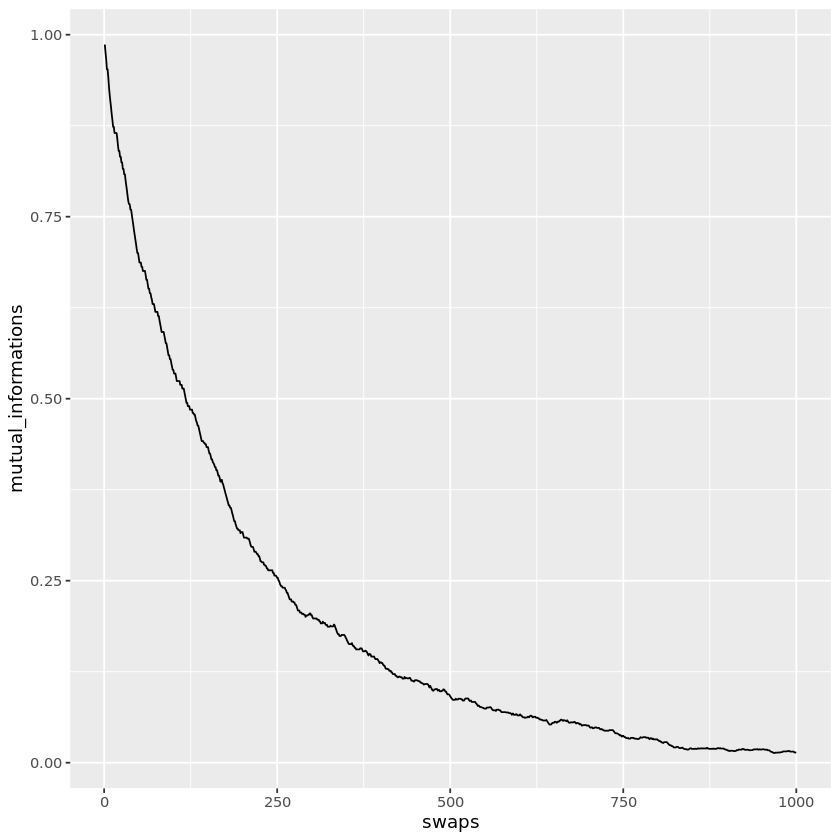

In [15]:
swaps <- seq(1000);
mutual_informations <- c()
cc <- voltages_wide$label;
for(i in swaps){
  indices <- sample(seq(length(cc)), 2, replace=F);
  tmp <- cc[[indices[[1]]]];
  cc[[indices[[1]]]] <- cc[[indices[[2]]]];
  cc[[indices[[2]]]] <- tmp;
  mutual_informations <- c(mutual_informations, normalized_mutinf(voltages_wide$label, cc))
}
df <- tibble(swaps=swaps, mutual_informations=mutual_informations);
ggplot(df, aes(swaps, mutual_informations)) + geom_line();

## Beyond K-Means
We'd like to point you to the documentation from scikit-learn's clustering module.

From a user's point of view this table does a good job of giving you an intuition about what clustering algorithms are good for and how they fail in particular situations.

![](sphx_glr_plot_cluster_comparison_001.png)

Just like with dimensionality reduction, there is a relationship between the methods you use and the assumptions you make about your data's mathematical structure.

**K-means assumes you have vectorial data** which is furthermore **distributed into uniformly shaped Gaussian of about the same size and shape**. It also assumes that an element is either in a cluster or not - so the probabilistic nature of the Gaussian is suppressed in favor of simplicity.

If we relax that last assumption we get fuzzy-k-means. In this algorithm each entity is only assigned a probability of being in a cluster based on its distance from the center. Fuzzy-k-means works well when your data is distributed in concentric clusters by may have outliers that you want to "automatically ignore".

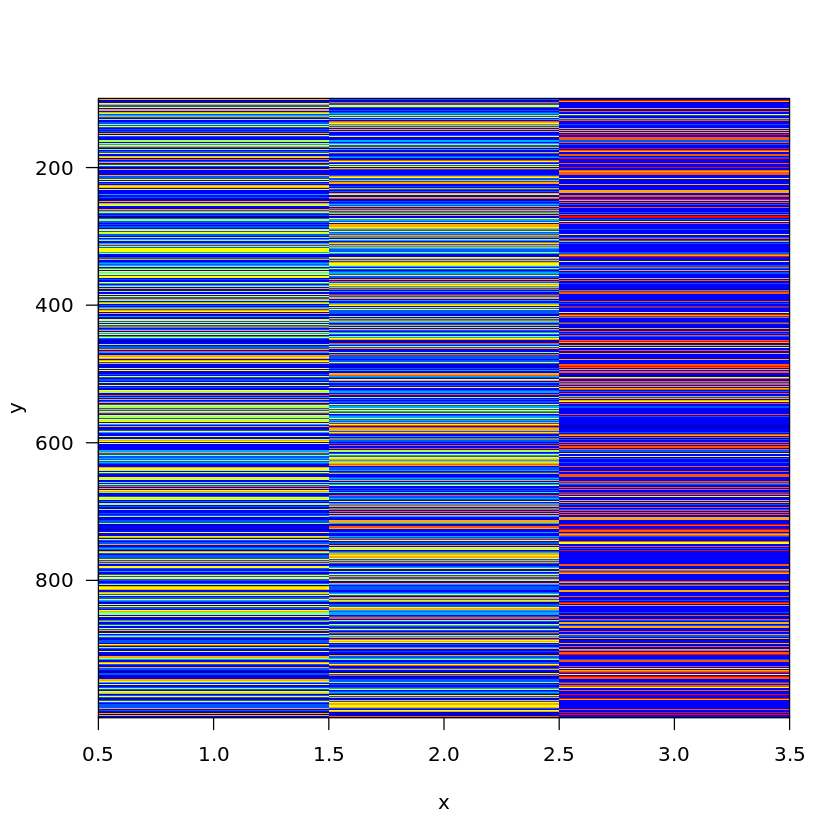

In [16]:
library(ppclust);

results <- fcm(voltages_matrix, centers=3);
imagesc(results$u)

For each data point we get 3 probabilities. To extract the clusters we
can say:

In [17]:
best_clusters <- results$u %>%
  as_tibble(rownames = "index") %>%
  rowwise() %>%
  mutate(
    best = which.max(c(`Cluster 1`, `Cluster 2`, `Cluster 3`)),
    best_p = max(c(`Cluster 1`, `Cluster 2`, `Cluster 3`))
  ) %>%
  ungroup()
best_clusters

index,Cluster 1,Cluster 2,Cluster 3,best,best_p
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0.16731017,0.72712823,0.10556161,2,0.7271282
2,0.69140824,0.19425153,0.11434023,1,0.6914082
3,0.15083000,0.75932401,0.08984599,2,0.7593240
4,0.06178776,0.06506831,0.87314392,3,0.8731439
5,0.13053326,0.13357220,0.73589455,3,0.7358945
6,0.12567026,0.79393738,0.08039236,2,0.7939374
7,0.56738918,0.27369440,0.15891642,1,0.5673892
8,0.61398561,0.23229339,0.15372099,1,0.6139856
9,0.68943680,0.18622956,0.12433364,1,0.6894368


Its handy to see how we might visualize this data as well.

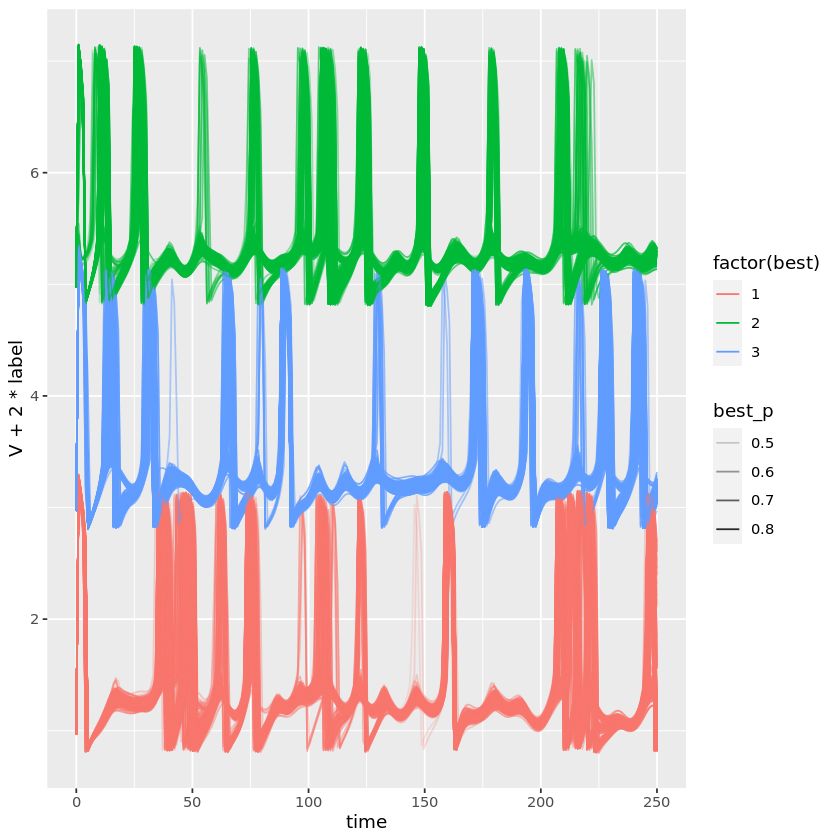

In [18]:
library(dplyr)

voltages_ex <- voltages_wide %>%
  mutate(
    best = best_clusters$best,
    best_p = best_clusters$best_p
  )

ggplot(
  voltages %>%
    inner_join(
      dplyr::select(voltages_ex, trial, label, best, best_p),
      by = c("trial", "label")
    ),
  aes(time, V + 2 * label)
) +
  geom_line(
    aes(
      color = factor(best),
      alpha = best_p,
      group = sprintf("%d:%d", trial, label)
    )
  )

## Gaussian Mixture Models

If we relax the assumption that our Gaussian are uniform then we get
Gaussian Mixture Models. A GMM assumes that the data data is drawn from
N Gaussian distributions whose individual parameters are estimated from
the data. This can handle clusters of different sizes and shapes more
easily.

Expectation maximization is used to fit the parameters, but the whole
thing works more or less the way k-means does: we begin with some
estimates of groups and then modify the parameters of our model to
maximize the likelihood of the data we have.

$$
\mathcal{L}(\theta) = \sum_{i=1}^{N} \log \left( \sum_{k=1}^{K} \pi_k \, p(\mathbf{x}_i | \mu_k, \Sigma_k) \right)
$$

Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘mclust’


The following object is masked from ‘package:purrr’:

    map


Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust EVV (ellipsoidal, equal volume) model with 2 components: 

 log-likelihood   n df       BIC       ICL
      -837.8937 200 10 -1728.771 -1773.557

Clustering table:
  1   2 
100 100 

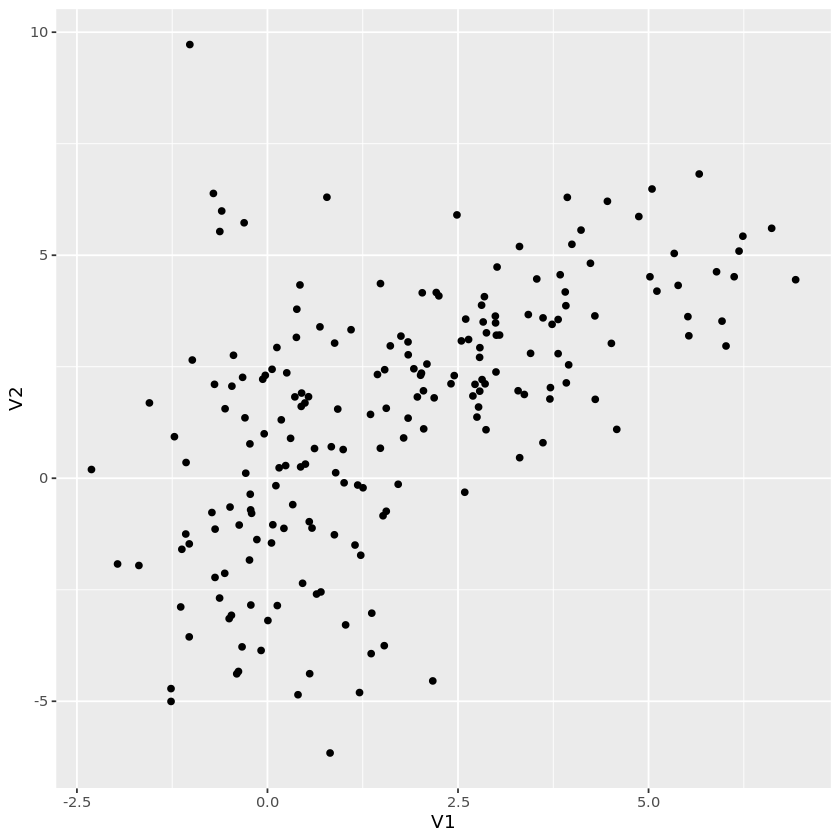

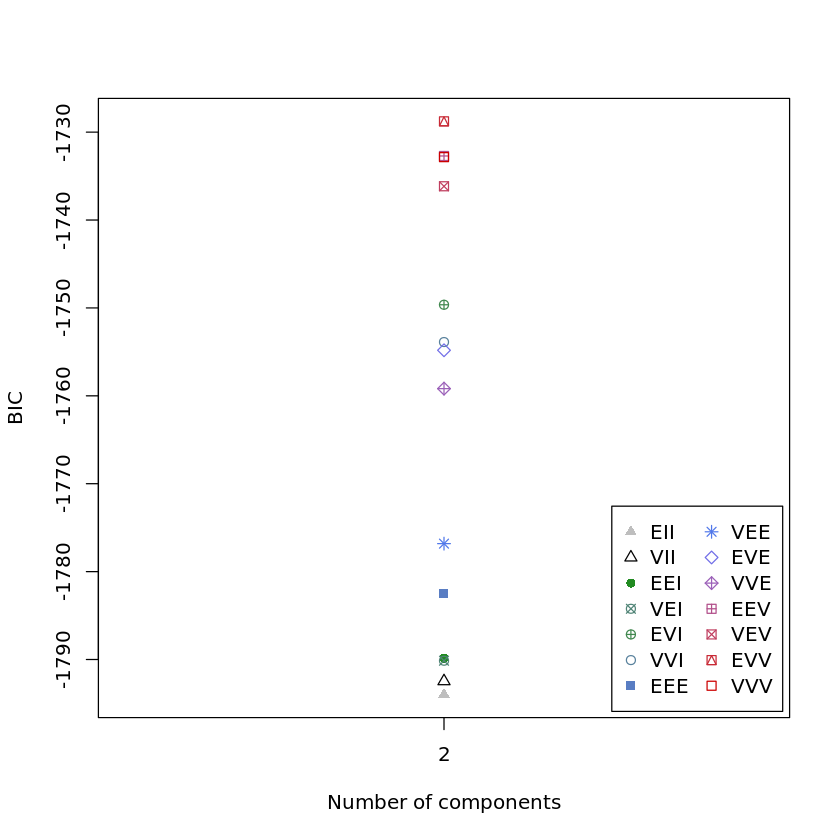

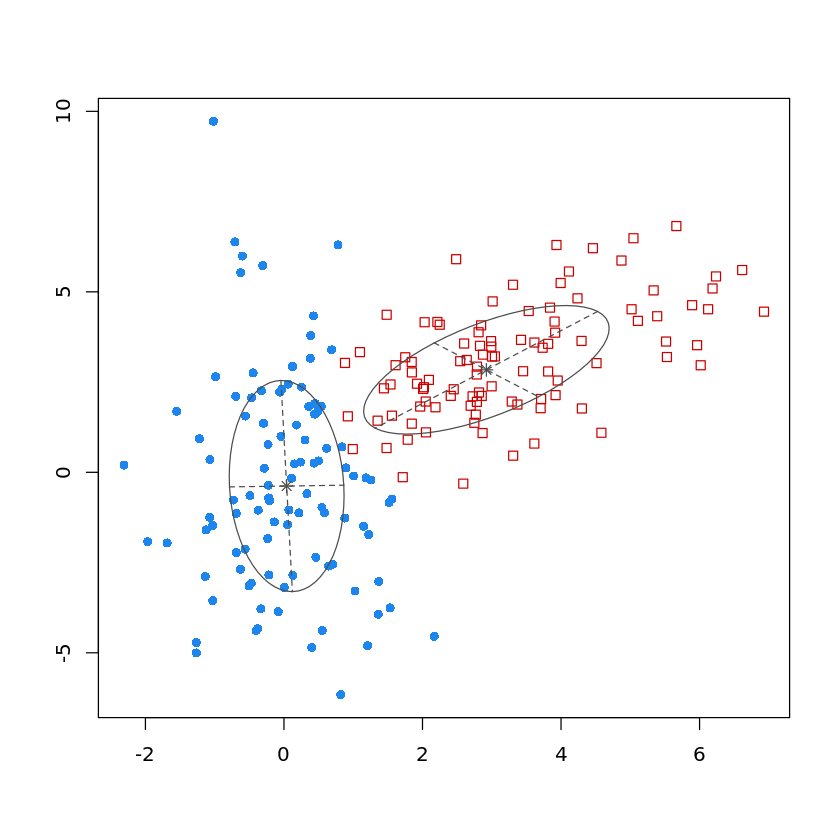

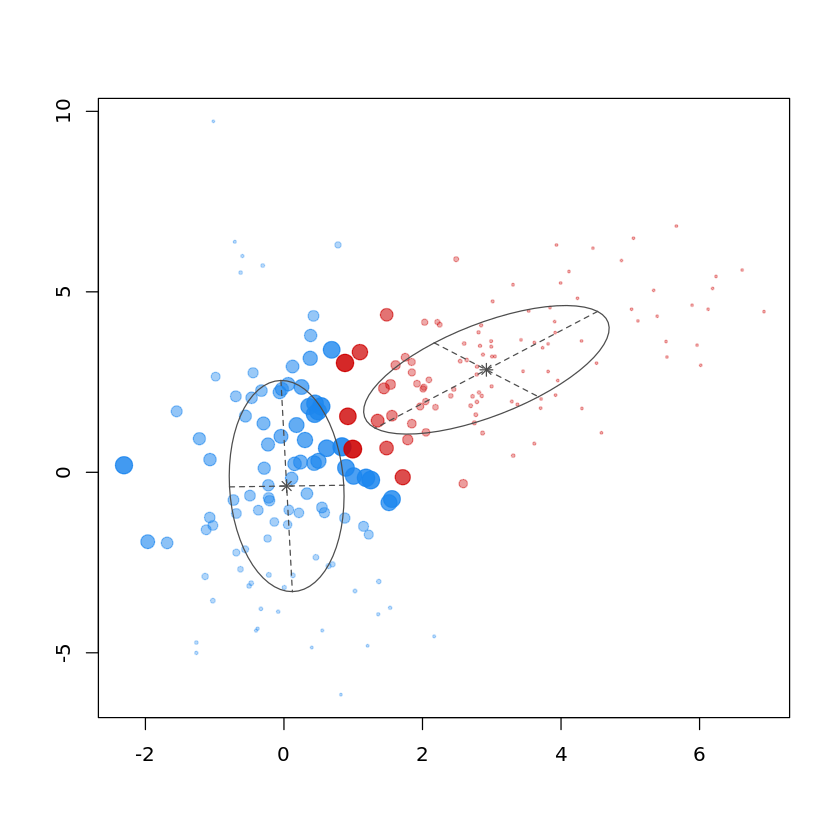

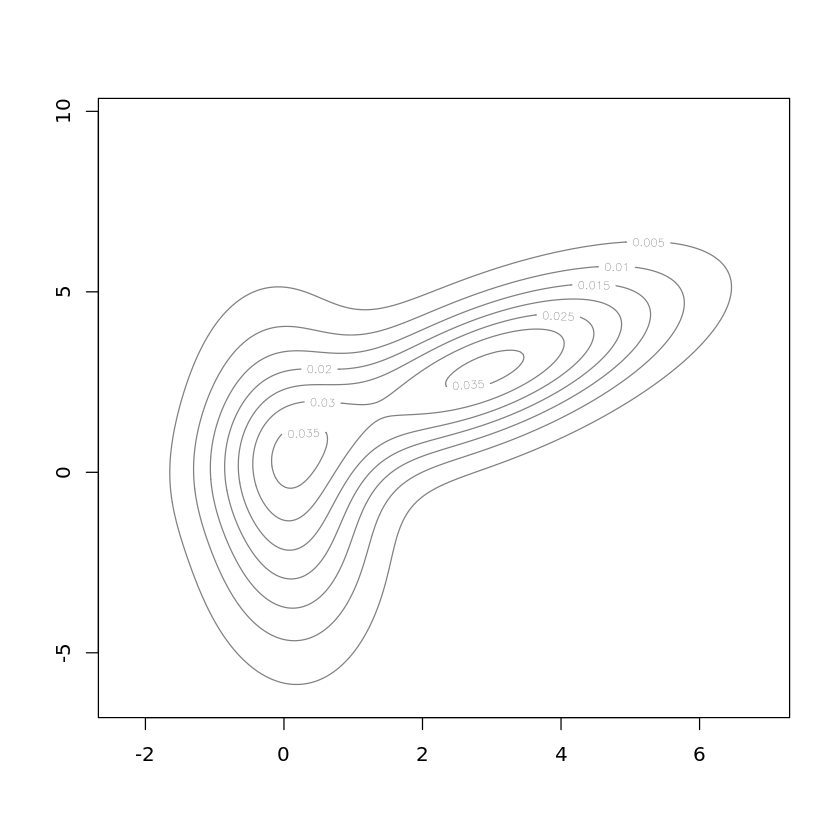

In [19]:
# Install and load the mclust package
library(mclust)

# Generate synthetic 2D data with different standard deviations
set.seed(123)
n <- 100
data1 <- cbind(rnorm(n, mean=0, sd=1), rnorm(n, mean=0, sd=3))

# Generate another Gaussian cluster with different standard deviations and rotate it
data2 <- cbind(rnorm(n, mean=0, sd=2), rnorm(n, mean=0, sd=1))
theta <- pi / 4  # 45 degree rotation
rotation_matrix <- matrix(c(cos(theta), -sin(theta), sin(theta), cos(theta)), ncol=2)
data2 <- data2 %*% rotation_matrix
data2 <- data2 + matrix(rep(3, 2 * n), ncol=2)  # Translate to (3, 3)

# Combine the data
data <- rbind(data1, data2)

ggplot(data %>% as_tibble(), aes(V1, V2)) + geom_point()

# Fit the Gaussian Mixture Model
fit <- Mclust(data, G=2)

# Summary of the fit
summary(fit)

# Plot the results
plot(fit)

## Spectral Clustering

Spectral clustering reduces the assumptions you make about the data down
to an extremely minimal one:

Two points are more likely to be in the same cluster if they are close
to one another.

This is similar to the assumption that we made when we looked at
multidimensional scaling, which requires *only* a metric on the original
data. The mere existence of a metric is a much weaker condition than the
existence of a vector space, and thus we can work with substantially
more types of data. In fact, spectral clustering is weaker even than a
vector space: its input data is just a matrix saying which points are
similar to one another by any criteria.

This could be as simple as "person X is friends with person Y" or depend
on more structure: two points count as "similar" if they are within a
certain distance of one-another according to a metric.

Once we have this data we can calculate something called the "Graph
Laplacian" which characterizes the graph connecting your data set. The
eigenvectors of this matrix can be truncated to form a low dimensional
representation of the data in this "connectivity space" and then regular
k-means can be used to cluster the points. The results are quite good.

I am going to try harder than usual to motivate this procedure today:

$$
L = D - A
$$

Which is made of two matrices:

$$
D = deg(v_i)_j = \delta_{ij} *\sum_i{C_{ik}}
$$

Here $C_{ik}$ is just 1 when i and k are connected and 0 otherwise.

A is the adjacency matrix:

$$
A_{ij} = \begin{cases}1 & \text{if there is an edge between } v_i \text{ and } v_j, \\0 & \text{otherwise}.\end{cases}
$$

Let's imagine a graph with N nodes. We are given a function on the nodes
of some kind which assigns a value to each node.

We might want to define a derivative of this function on the graph
which, intuitively, would be the difference between each node and its
along each edge. That would have to do with the difference between
adjecent nodes. Define $B_{\alpha i}$

$$
B_{\alpha i} =\begin{cases}+1 & \text{if vertex $v$ is the head of edge $e$,} \\-1 & \text{if vertex $v$ is the tail of edge $e$,} \\0  & \text{otherwise.}\end{cases}
$$

Where we will define the convention that greek indices go over edges and
latin indices go over nodes.

If f is a function on the nodes then

$$
B_{\alpha i} f(v^i) = f_(u_i) - f_(u_{\text{via } \alpha})
$$

Spectral clustering is an expensive operation so let's reduce our data
down using PCA first.


Attaching package: ‘kernlab’


The following object is masked from ‘package:matlab’:

    size


The following object is masked from ‘package:purrr’:

    cross


The following object is masked from ‘package:ggplot2’:

    alpha




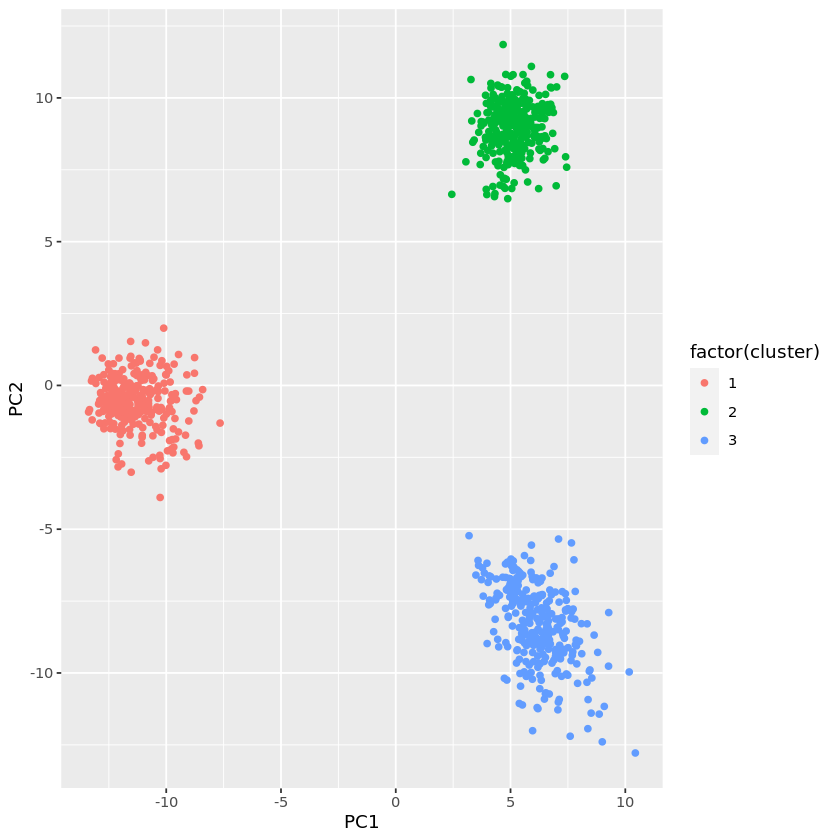

In [20]:
library(dplyr)
library(kernlab)
library(readr)
library(ggplot2)
library(rdist)

# Subset data so it runs faster

set.seed(0)
subset_idx <- sample(nrow(voltages_wide), min(1000, nrow(voltages_wide)))  # subset 1000 rows
voltages_subset <- voltages_wide[subset_idx, ]

# Use PCA first

pca.r <- prcomp(
  dplyr::select(voltages_subset, -trial, -label, -`0`),
  scale. = TRUE,
  center = TRUE
)$x %>% as_tibble()

pca.r$label <- voltages_subset$label
ld <- pca.r %>% dplyr::select(PC1:PC10)

# This part was done in Python in the lecture. I included it in R so everything was together.

clustering <- specc(as.matrix(ld), centers = 3, kernel = "rbfdot", kpar = list(sigma = 0.05))
labels <- clustering@.Data
labels_df <- data.frame(labels = labels)

# Plotting

data <- ld
data$cluster <- labels_df$labels

ggplot(data, aes(PC1, PC2)) + geom_point(aes(color = factor(cluster)))

Spectral Clustering is computationally expensive, however, since it
works on the *distance* matrix which is, by its nature, nxn. This
becomes unmanageable quickly. You can cluster on a subset and then use
k-nearest neighbors to assign other points *if* you can capture the
meaningful variability in an acceptably small sample.

## Number of Clusters

Choosing the number of clusters is a dark art. In a sense, there is no
right answer without some prior knowledge. A common approach is to just
do a lot of clustering, plot the results with a dimensionality reduction
method, and reduce the number of clusters until things look right.

Remember, the value of doing a clustering is sometimes to just
automatically segment the data in some useful way. We don't always need
the clusters to be clean.

The reason this is a challenge is because you can always improve you
"goodness of fit" by adding more clusters. The model where you have as
many clusters as points clearly perfectly models the data.

Experiment, make plots. Make summaries.

Or just use a standard method. This is the gap statistic method. The
basic idea is to compare the clustering for each value of K to a cluster
of data "randomized" into the same domain as the original data. We then
compute the dispersion of the two clusterings and look at the
difference. We look for a "knee" and that is our cluster number. This is
ad-hoc but at least standard.


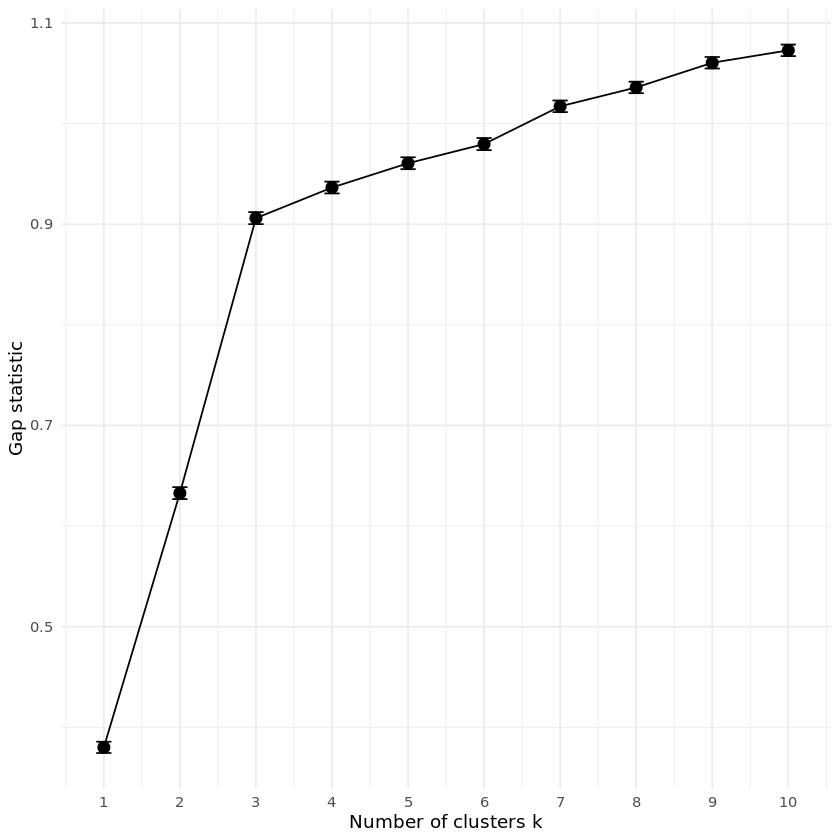

In [23]:
library(cluster);
set.seed(0)  # for reproducibility

r <- clusGap(
  ld %>% as.matrix(),
  FUN = function(data, k) {
    kmeans(data, centers = k, nstart = 20, iter.max = 100)
  },
  K.max = 10,
  B = 50
)

gap_df <- data.frame(
  k = 1:nrow(r$Tab),
  gap = r$Tab[, "gap"],
  SE.sim = r$Tab[, "SE.sim"]
)

ggplot(gap_df, aes(k, gap)) +
  geom_line() +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = gap - SE.sim, ymax = gap + SE.sim), width = 0.2) +
  scale_x_continuous(breaks = 1:nrow(r$Tab)) +
  labs(x = "Number of clusters k", y = "Gap statistic") +
  theme_minimal()